# Team 3 - Team Assignment
## Md Mazharul Anower, Xiaofu Hong,Bo Jiang, George Kepertis
# Analyzing weather in Australia
Data Source: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

### Description from Kaggle: 

Content
This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

Source & Acknowledgements
Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data.
An example of latest weather observations in Canberra: http://www.bom.gov.au/climate/dwo/IDCJDW2801.latest.shtml

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml
Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data.

Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

In [1]:
!conda install --yes geopy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/miniconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          98 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0



geopy-2.1.0          | 64 KB     | ##################################### | 100% 
geog

In [2]:
!conda install adjustText 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/miniconda3

  added / updated specs:
    - adjusttext


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    adjusttext-0.7.3.1         |             py_1          11 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          11 KB

The following NEW packages will be INSTALLED:

  adjusttext         conda-forge/noarch::adjusttext-0.7.3.1-py_1



adjusttext-0.7.3.1   | 11 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


First, we define a custom schema for the data to make sure that our columns have the correct data types. Then we load the data into spark specifying the schema as well as the format of the Null values in our data.

In [1]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DateType, DoubleType, LongType, ArrayType

mySchema = StructType([ \
    StructField("Date",DateType(),True), \
    StructField("Location",StringType(),True), \
    StructField("MinTemp",DoubleType(),True), \
    StructField("MaxTemp", DoubleType(), True), \
    StructField("Rainfall", DoubleType(), True), \
    StructField("Evaporation", DoubleType(), True), \
    StructField("Sunshine", DoubleType(), True), \
    StructField("WindGustDir", StringType(), True), \
    StructField("WindGustSpeed", DoubleType(), True),\
    StructField("WindDir9am", StringType(), True), \
    StructField("WindDir3pm", StringType(), True), \
    StructField("WindSpeed9am", DoubleType(), True), \
    StructField("WindSpeed3pm", DoubleType(), True), \
    StructField("Humidity9am", DoubleType(), True), \
    StructField("Humidity3pm", DoubleType(), True), \
    StructField("Pressure9am", DoubleType(), True), \
    StructField("Pressure3pm", DoubleType(), True), \
    StructField("Cloud9am", LongType(), True), \
    StructField("Cloud3pm", LongType(), True), \
    StructField("Temp9am", DoubleType(), True), \
    StructField("Temp3pm", DoubleType(), True), \
    StructField("RainToday", StringType(), True), \
    StructField("RainTomorrow", StringType(), True)
  ])

df = spark.read.format('csv')\
    .schema(mySchema)\
    .option("header", True)\
    .option("nullValue","NA")\
    .load('gs://is843-team3-2021/notebooks/jupyter/project/weatherAUS.csv')

df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: long (nullable = true)
 |-- Cloud3pm: long (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Below, we define some functions that will help us get the latitude and longitude of each location. We will add these two values as columns in our dataframe as they may be helpful for the latter part of our project where we try to predict rainfall. 

In addition, we convert the "Yes" and "No" values in the RainToday and RainTomorrow columns to 0 and 1, as well as adding spaces to the location names so we can use the geopy API to get the coordinates.

In [2]:
from  geopy.geocoders import Nominatim
from pyspark.sql.functions import udf, col, regexp_replace
import re
import numpy as np

def get_latitude(city):
    geolocator = Nominatim(user_agent = 'team')
    country = "Australia"
    loc = geolocator.geocode(city+','+ country)
    return loc.latitude

def get_longitude(city):
    geolocator = Nominatim(user_agent = 'team')
    country = "Australia"
    loc = geolocator.geocode(city+','+ country)
    return loc.longitude

def clean_city_name(city):
    return re.sub(r"(\w)([A-Z])", r"\1 \2", city)

def yes_no_to_0_1(word):
    if word == "Yes":
        return 1
    return 0

cleanCityName = udf(lambda x: clean_city_name(x), StringType())
spark.udf.register("cleanCityName", cleanCityName)

yesNoTo01 = udf(lambda x: yes_no_to_0_1(x), LongType())
spark.udf.register("yesNoTo01", yesNoTo01)
    
#Defining these as udf's causes issues later because of the lazy evaluation. 
#The API gets called every time an operation is performed causing us to run out of requests   

# getLatitude = udf(lambda x: get_latitude(x), DoubleType())
# spark.udf.register("getLatitude", getLatitude)

# getLongitude = udf(lambda x: get_longitude(x), DoubleType())
# spark.udf.register("getLongitude", getLongitude)

<function __main__.<lambda>(x)>

Here we do the conversion of "Yes" and "No" to 0 and 1

In [3]:
df = df.withColumn("RainToday",yesNoTo01(col("RainToday")))
df = df.withColumn("RainTomorrow",yesNoTo01(col("RainTomorrow"))) 
df.take(2)

[Row(Date=datetime.date(2008, 12, 1), Location='Albury', MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, Evaporation=None, Sunshine=None, WindGustDir='W', WindGustSpeed=44.0, WindDir9am='W', WindDir3pm='WNW', WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, Cloud9am=8, Cloud3pm=None, Temp9am=16.9, Temp3pm=21.8, RainToday=0, RainTomorrow=0),
 Row(Date=datetime.date(2008, 12, 2), Location='Albury', MinTemp=7.4, MaxTemp=25.1, Rainfall=0.0, Evaporation=None, Sunshine=None, WindGustDir='WNW', WindGustSpeed=44.0, WindDir9am='NNW', WindDir3pm='WSW', WindSpeed9am=4.0, WindSpeed3pm=22.0, Humidity9am=44.0, Humidity3pm=25.0, Pressure9am=1010.6, Pressure3pm=1007.8, Cloud9am=None, Cloud3pm=None, Temp9am=17.2, Temp3pm=24.3, RainToday=0, RainTomorrow=0)]

## Exploratory Data Analysis

In [4]:
print('Number of total rows: %i'%(df.count())) 

Number of total total rows: 145460


Below we get the coordinates of each location. The reason this is done in pandas and not spark is because spark tries to call the geopy API every time an action is performed which is expensive and eventually we run out of requests.

Additionally, one of the names (Pearce RAAF) gets processed incorrectly, so we process it manually. We also have to convert it back to the incorrect format for the purposes of joining to the original dataframe

In [5]:
locations = df.selectExpr('Location').distinct().toPandas()
locations['Location'] = locations.apply(lambda row : clean_city_name(row['Location']), axis = 1) 
index = locations.index[locations.Location == 'Pearce RA AF']
locations.loc[index,'Location'] = 'Pearce RAAF'
locations['Latitude'] = locations.apply(lambda row : get_latitude(row['Location']), axis = 1) 
locations['Longitude'] = locations.apply(lambda row : get_longitude(row['Location']), axis = 1) 
index = locations.index[locations.Location == 'Pearce RAAF'] 
locations.loc[index,'Location'] = 'Pearce RA AF' 
locations = spark.createDataFrame(locations)
locations.show(5)

+--------------+-----------+-----------------+
|      Location|   Latitude|        Longitude|
+--------------+-----------+-----------------+
|        Cairns|-16.9206657|      145.7721854|
|Norfolk Island|-29.0289575|167.9587289126371|
|       Bendigo|-36.7588767|      144.2825931|
|      Canberra|-35.2975906|      149.1012676|
|         Cobar|-31.4983333|      145.8344444|
+--------------+-----------+-----------------+
only showing top 5 rows



We look at the locations in our dataset on a map of Australia

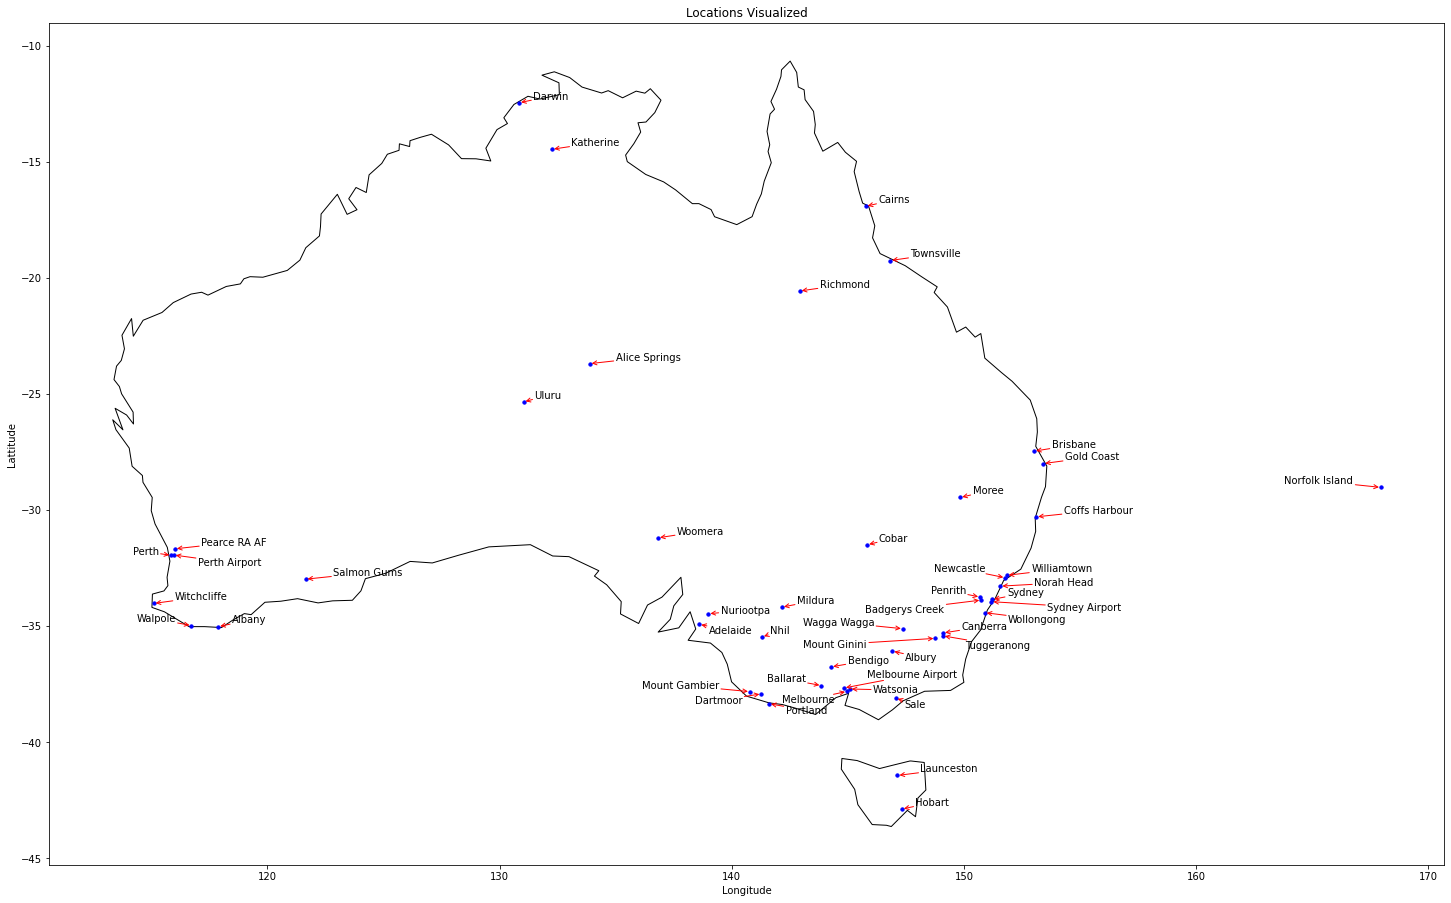

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text
locations_pd = locations.toPandas()
locations_gpd =  gpd.GeoDataFrame(locations_pd, geometry=gpd.points_from_xy(locations_pd.Longitude, locations_pd.Latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world[world.name == 'Australia'].plot(color='white', edgecolor='black', figsize = (25,30))
locations_gpd.plot(ax=base, color='blue', markersize=11, marker = 'o')
texts = []
for x, y, label in zip(locations_gpd.geometry.x, locations_gpd.geometry.y, locations_gpd.Location):
    texts.append(plt.text(x,y,label))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.title('Locations Visualized')
adjust_text(texts, ax = base,force_points = (0.5,0.8),force_text = (0.5,0.8), expand_text = (1,1),expand_points = (1.8,1.3),arrowprops=dict(arrowstyle="->", color='r', lw=1))
plt.show()

We finally add the coordinates to our original dataframe. As we can see, the merge worked well and we did not lose any rows.

In [7]:
df = df.withColumn('Location',cleanCityName(col('Location')))
df = df.join(locations,on  = 'Location',how = 'left')
df.take(2)

[Row(Location='Melbourne Airport', Date=datetime.date(2009, 1, 1), MinTemp=11.2, MaxTemp=19.9, Rainfall=0.0, Evaporation=5.6, Sunshine=8.8, WindGustDir='SW', WindGustSpeed=69.0, WindDir9am='W', WindDir3pm='SW', WindSpeed9am=33.0, WindSpeed3pm=43.0, Humidity9am=55.0, Humidity3pm=37.0, Pressure9am=1005.1, Pressure3pm=1006.4, Cloud9am=7, Cloud3pm=7, Temp9am=15.9, Temp3pm=18.1, RainToday=0, RainTomorrow=1, Latitude=-37.667111000000006, Longitude=144.83348076679553),
 Row(Location='Melbourne Airport', Date=datetime.date(2009, 1, 2), MinTemp=7.8, MaxTemp=17.8, Rainfall=1.2, Evaporation=7.2, Sunshine=12.9, WindGustDir='SSE', WindGustSpeed=56.0, WindDir9am='SW', WindDir3pm='SSE', WindSpeed9am=31.0, WindSpeed3pm=26.0, Humidity9am=50.0, Humidity3pm=43.0, Pressure9am=1018.0, Pressure3pm=1019.3, Cloud9am=6, Cloud3pm=7, Temp9am=12.5, Temp3pm=15.8, RainToday=1, RainTomorrow=0, Latitude=-37.667111000000006, Longitude=144.83348076679553)]

In [8]:
print('Number of total rows after merge: %i'%(df.count()))

Number of total total rows after merge: 145460


Next, we check the number of null values in each column

In [9]:
from pyspark.sql.functions import isnan, when, count, isnull
nulls = df.select([count(when(isnull(column), column)).alias("Null values in "+ column) for column in df.columns])
cols = nulls.columns
nulls.select(cols[:5]).show()
nulls.select(cols[5:10]).show()
nulls.select(cols[10:15]).show()
nulls.select(cols[15:20]).show()
nulls.select(cols[20:]).show()

+-----------------------+-------------------+----------------------+----------------------+-----------------------+
|Null values in Location|Null values in Date|Null values in MinTemp|Null values in MaxTemp|Null values in Rainfall|
+-----------------------+-------------------+----------------------+----------------------+-----------------------+
|                      0|                  0|                  1485|                  1261|                   3261|
+-----------------------+-------------------+----------------------+----------------------+-----------------------+

+--------------------------+-----------------------+--------------------------+----------------------------+-------------------------+
|Null values in Evaporation|Null values in Sunshine|Null values in WindGustDir|Null values in WindGustSpeed|Null values in WindDir9am|
+--------------------------+-----------------------+--------------------------+----------------------------+-------------------------+
|             

We notice that there are several columns that are missing up to one third of the values. This is something that we will have to address before training any models that will predict rain.

We also look at the summary statistics for each column.

In [10]:
cols = df.columns
df.select(cols[:5]).summary().show()
df.select(cols[5:10]).summary().show()
df.select(cols[10:15]).summary().show()
df.select(cols[15:20]).summary().show()
df.select(cols[20:]).summary().show()

+-------+--------+------------------+-----------------+-----------------+
|summary|Location|           MinTemp|          MaxTemp|         Rainfall|
+-------+--------+------------------+-----------------+-----------------+
|  count|  145460|            143975|           144199|           142199|
|   mean|    null|12.194034380968997|23.22134827564678|2.360918149916554|
| stddev|    null|6.3984949756632385|  7.1190488459791|8.478059737726367|
|    min|Adelaide|              -8.5|             -4.8|              0.0|
|    25%|    null|               7.6|             17.9|              0.0|
|    50%|    null|              12.0|             22.6|              0.0|
|    75%|    null|              16.9|             28.2|              0.8|
|    max| Woomera|              33.9|             48.1|            371.0|
+-------+--------+------------------+-----------------+-----------------+

+-------+------------------+------------------+-----------+------------------+----------+
|summary|       Evapo

In addition to having coordinates for each location, we also index each location and use that when looking at the correlations between numerical columns.

In [11]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='Location', outputCol='Location_idx')
df = df.drop('Location_idx')
indexer = indexer.fit(df)
df_idx = indexer.transform(df)

We drop the non numerical columns and look at the correlation matrix.

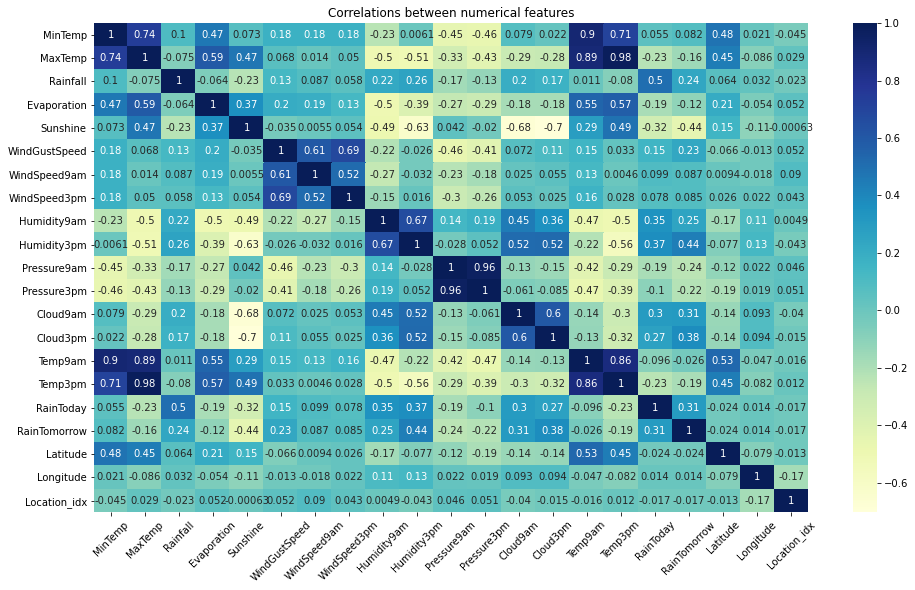

In [12]:
#looking at correlations between columns
from pyspark.sql.functions import corr
import seaborn as sns
import matplotlib.pyplot as plt

df_num = df_idx.drop("Date","Location","WindGustDir","WindDir9am","WindDir3pm").toPandas()
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Correlations between numerical features')
heatmap = sns.heatmap(df_num.corr(),ax = ax,annot=True,cmap="YlGnBu")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.show()

From above, we can see that the features which have the highest (in absolute value) correlation with RainTomorrow are Humidity9am, Cloud3pm, and Sunshine.

In the next part we plot the distributions of each numerical column. We begin with box plots

In [13]:
df_num_plots = df.drop('Location_idx',"Date","Location","WindGustDir","WindDir9am","WindDir3pm").toPandas()

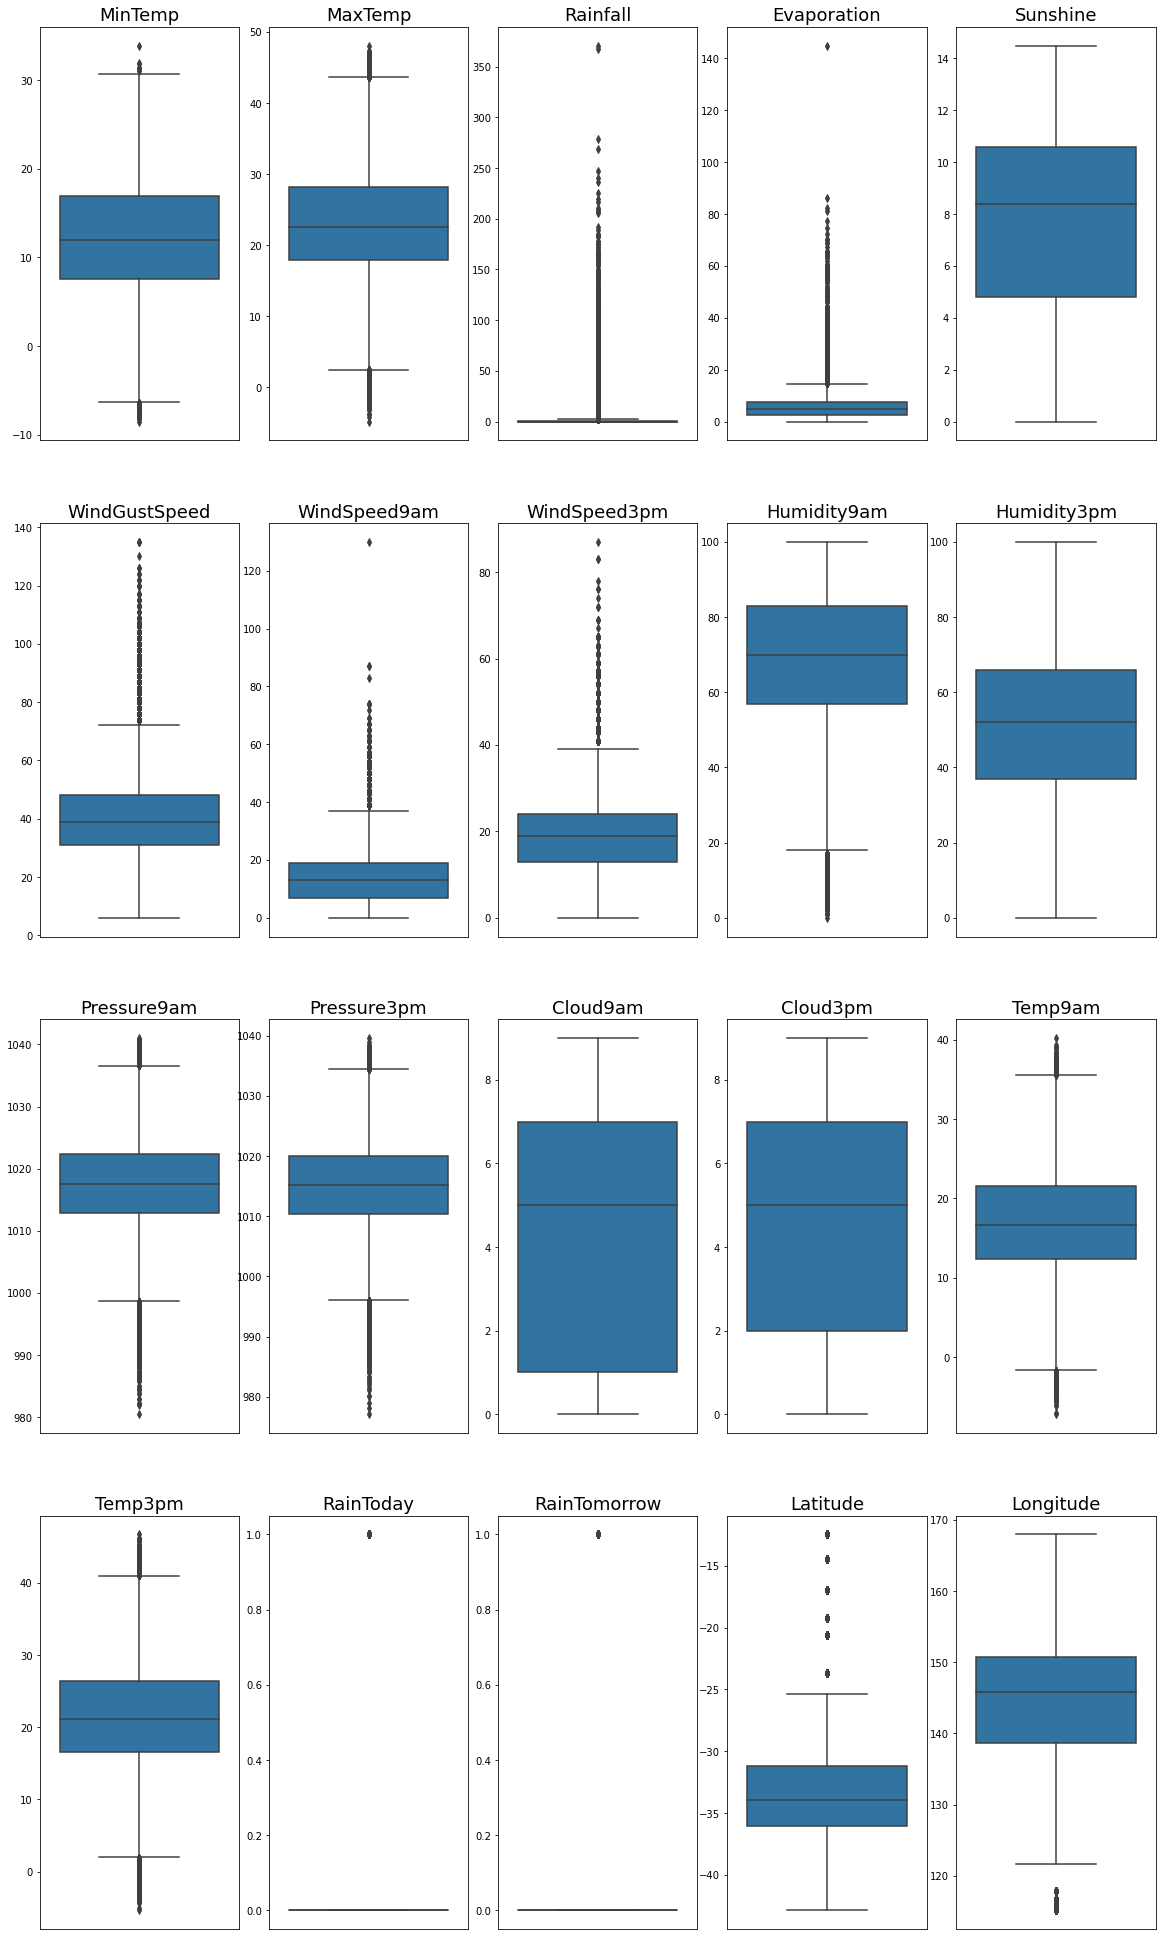

In [14]:
fig = plt.figure(figsize = (20,35))
fig.subplots_adjust(hspace=0.2, wspace=0.15)
i = 1

for col in df_num_plots.columns:    
    ax = fig.add_subplot(4, 5, i)
    ax.set_title(col, fontsize = 18)
    box = sns.boxplot(data = df_num_plots,ax=ax, y = col)
    box.set(ylabel = None, xticks = [])
    i+=1
plt.show()

Now we split on whether RainTomorrow is 0 or 1 to see whether there are any differences in the distribution.

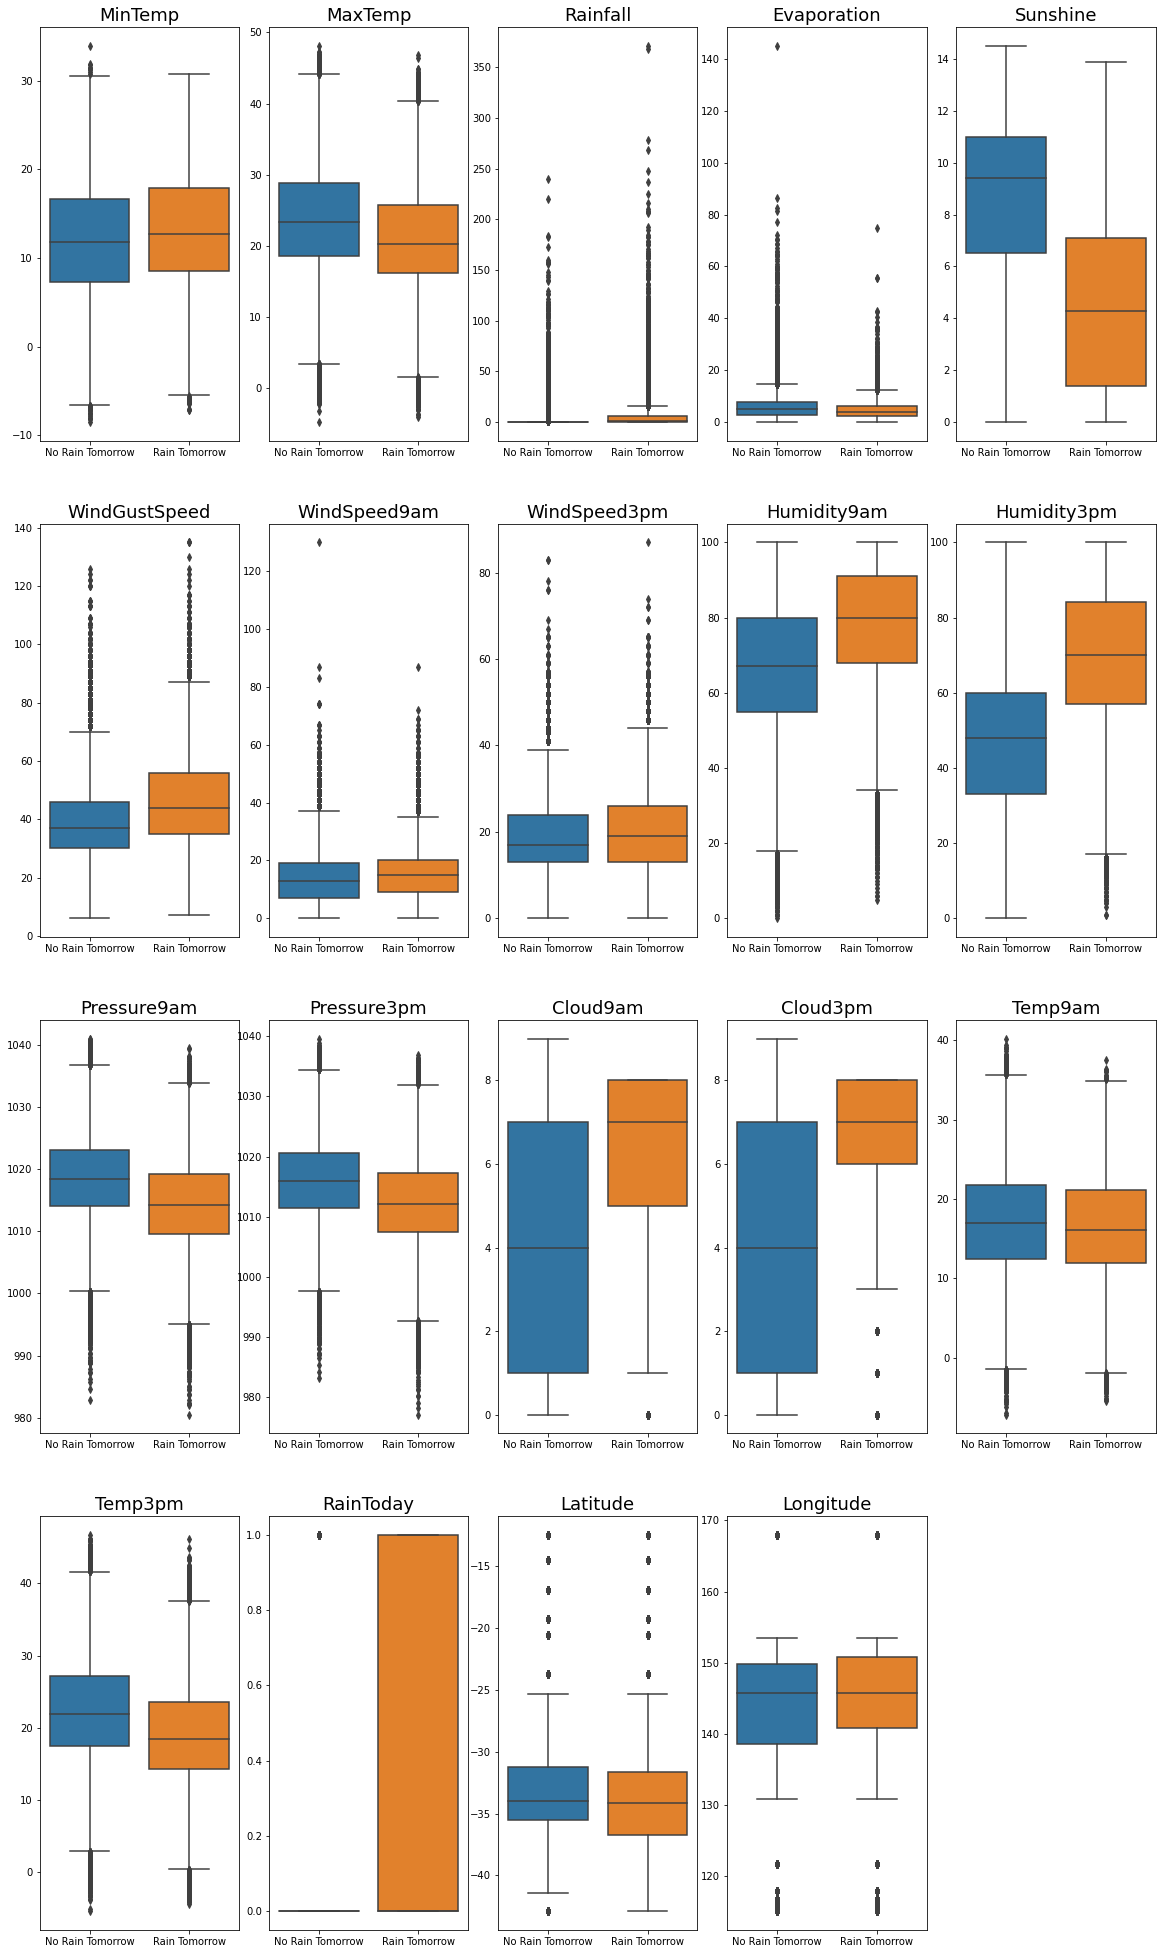

In [15]:
fig = plt.figure(figsize = (20,35))
fig.subplots_adjust(hspace=0.2, wspace=0.15)
i = 1
for col in df_num_plots.columns:
    if col != 'RainTomorrow':
        ax = fig.add_subplot(4, 5, i)
        ax.set_title(col, fontsize = 18)
        ax.set_xlabel('',fontsize = 10)
        box = sns.boxplot(data = df_num_plots,ax=ax, y = col, x = 'RainTomorrow')
        box.set(xlabel = '', ylabel = '',xticklabels = ['No Rain Tomorrow', 'Rain Tomorrow'])
        i+=1
    else:
        pass
plt.show()

Indeed, we notice that there are differences in the distributions of some columns based on the value of RainTomorrow. We expect that these will be important features in our prediction model.

We also look at a histogram for each numerical column. 

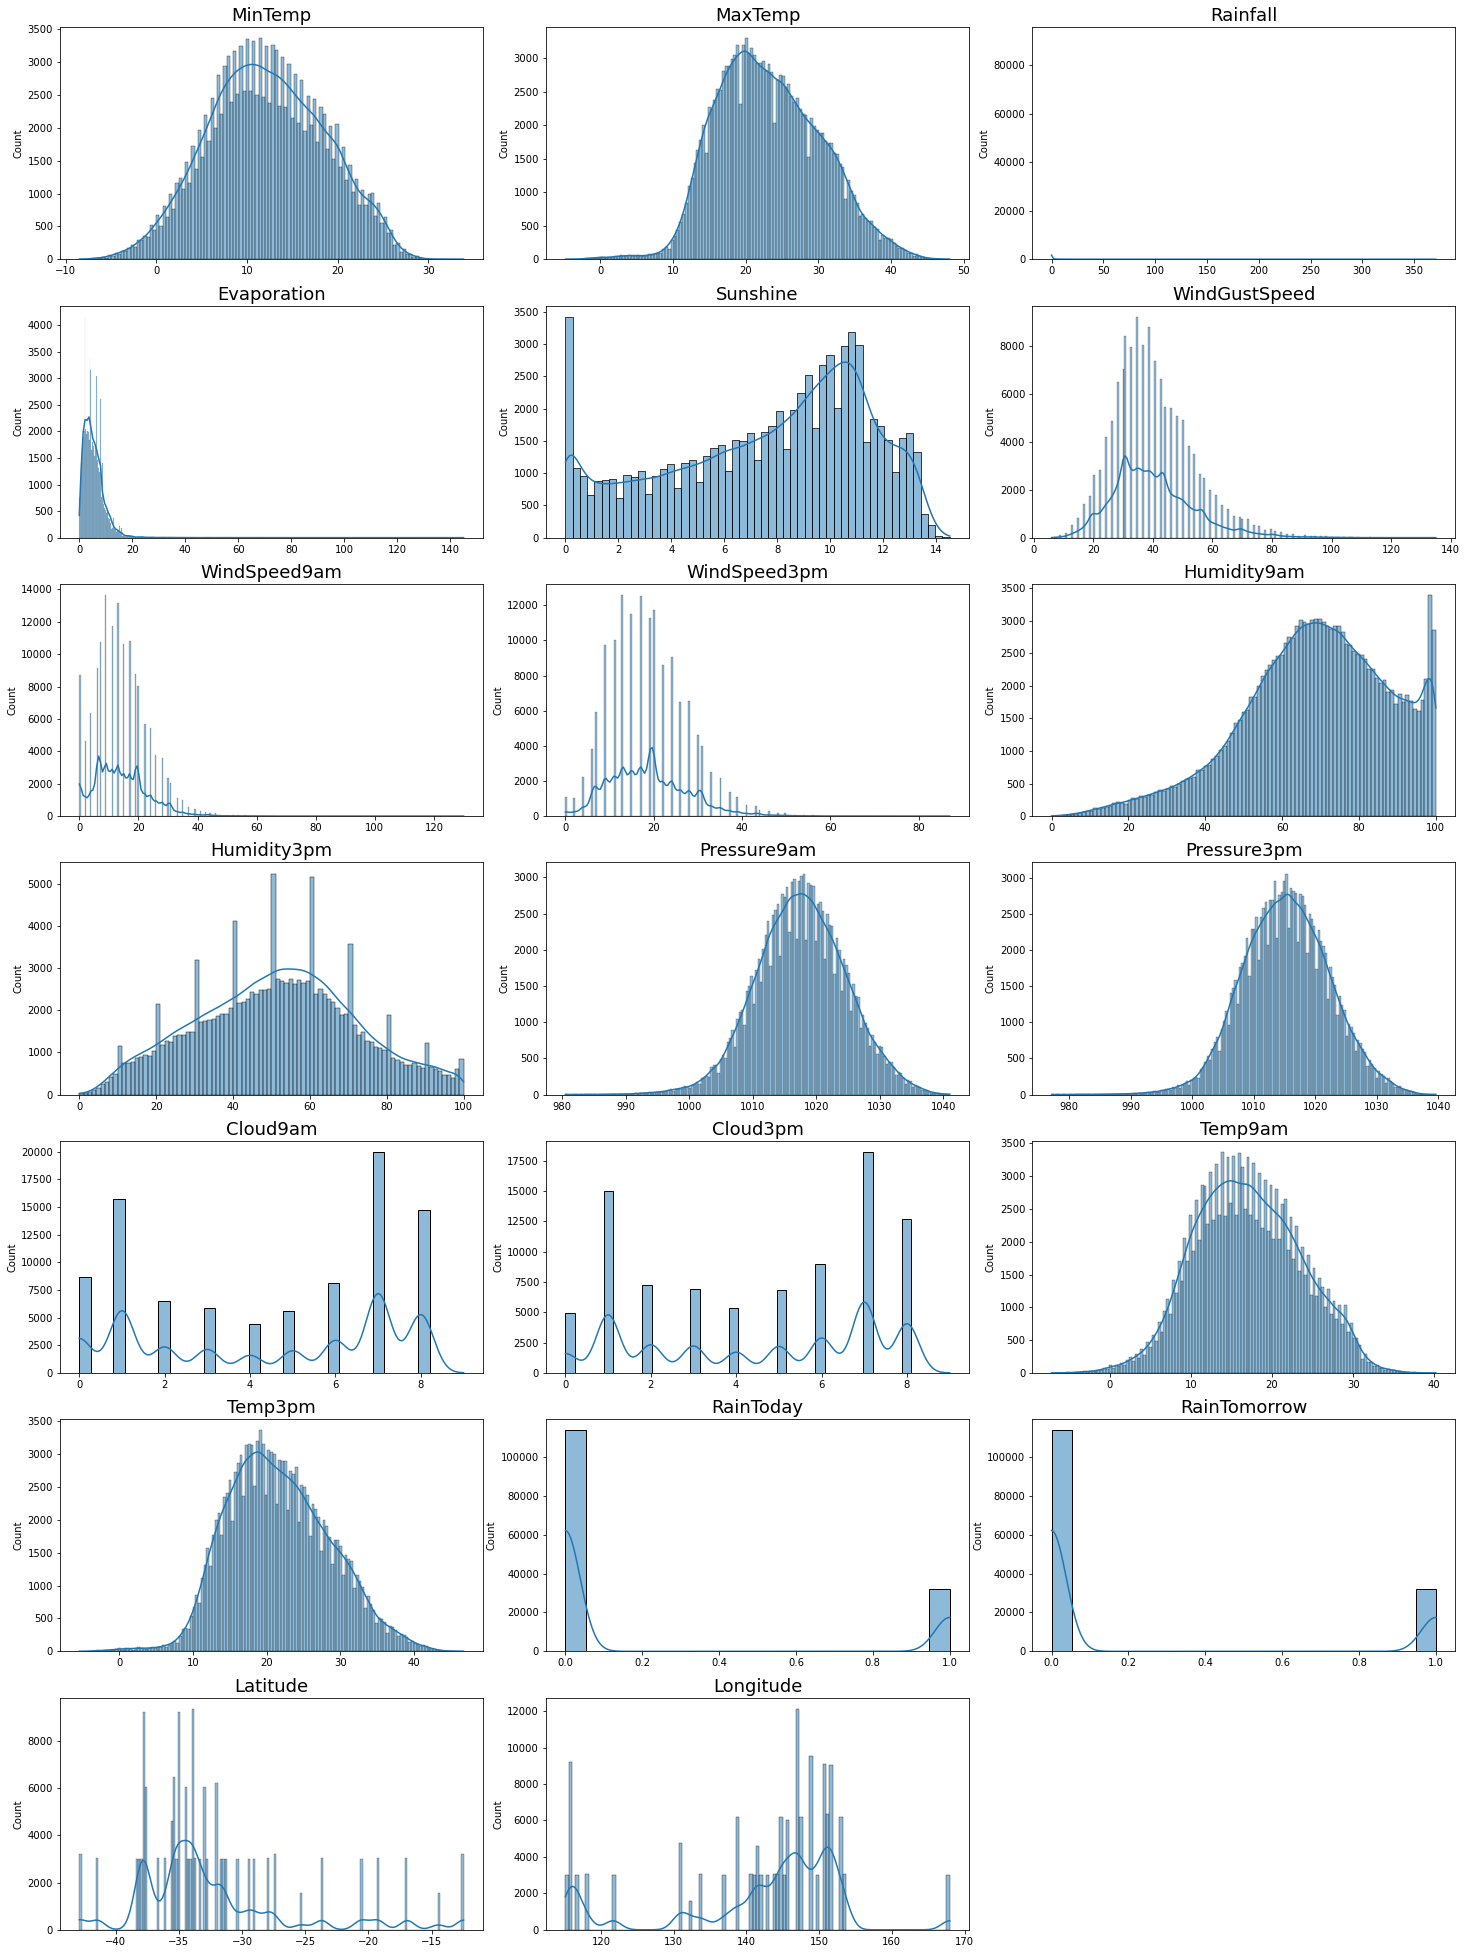

In [16]:
fig = plt.figure(figsize = (25,35))
fig.subplots_adjust(hspace=0.2, wspace=0.15)
i = 1
for col in df_num_plots.columns:    
    ax = fig.add_subplot(7, 3, i)
    ax.set_title(col, fontsize = 18)
    hist = sns.histplot(data = df_num_plots,x = col,ax=ax,kde=True)
    hist.set(xlabel = None)
    i+=1
plt.show()

Once again, we hue by the value of RainTomorrow.

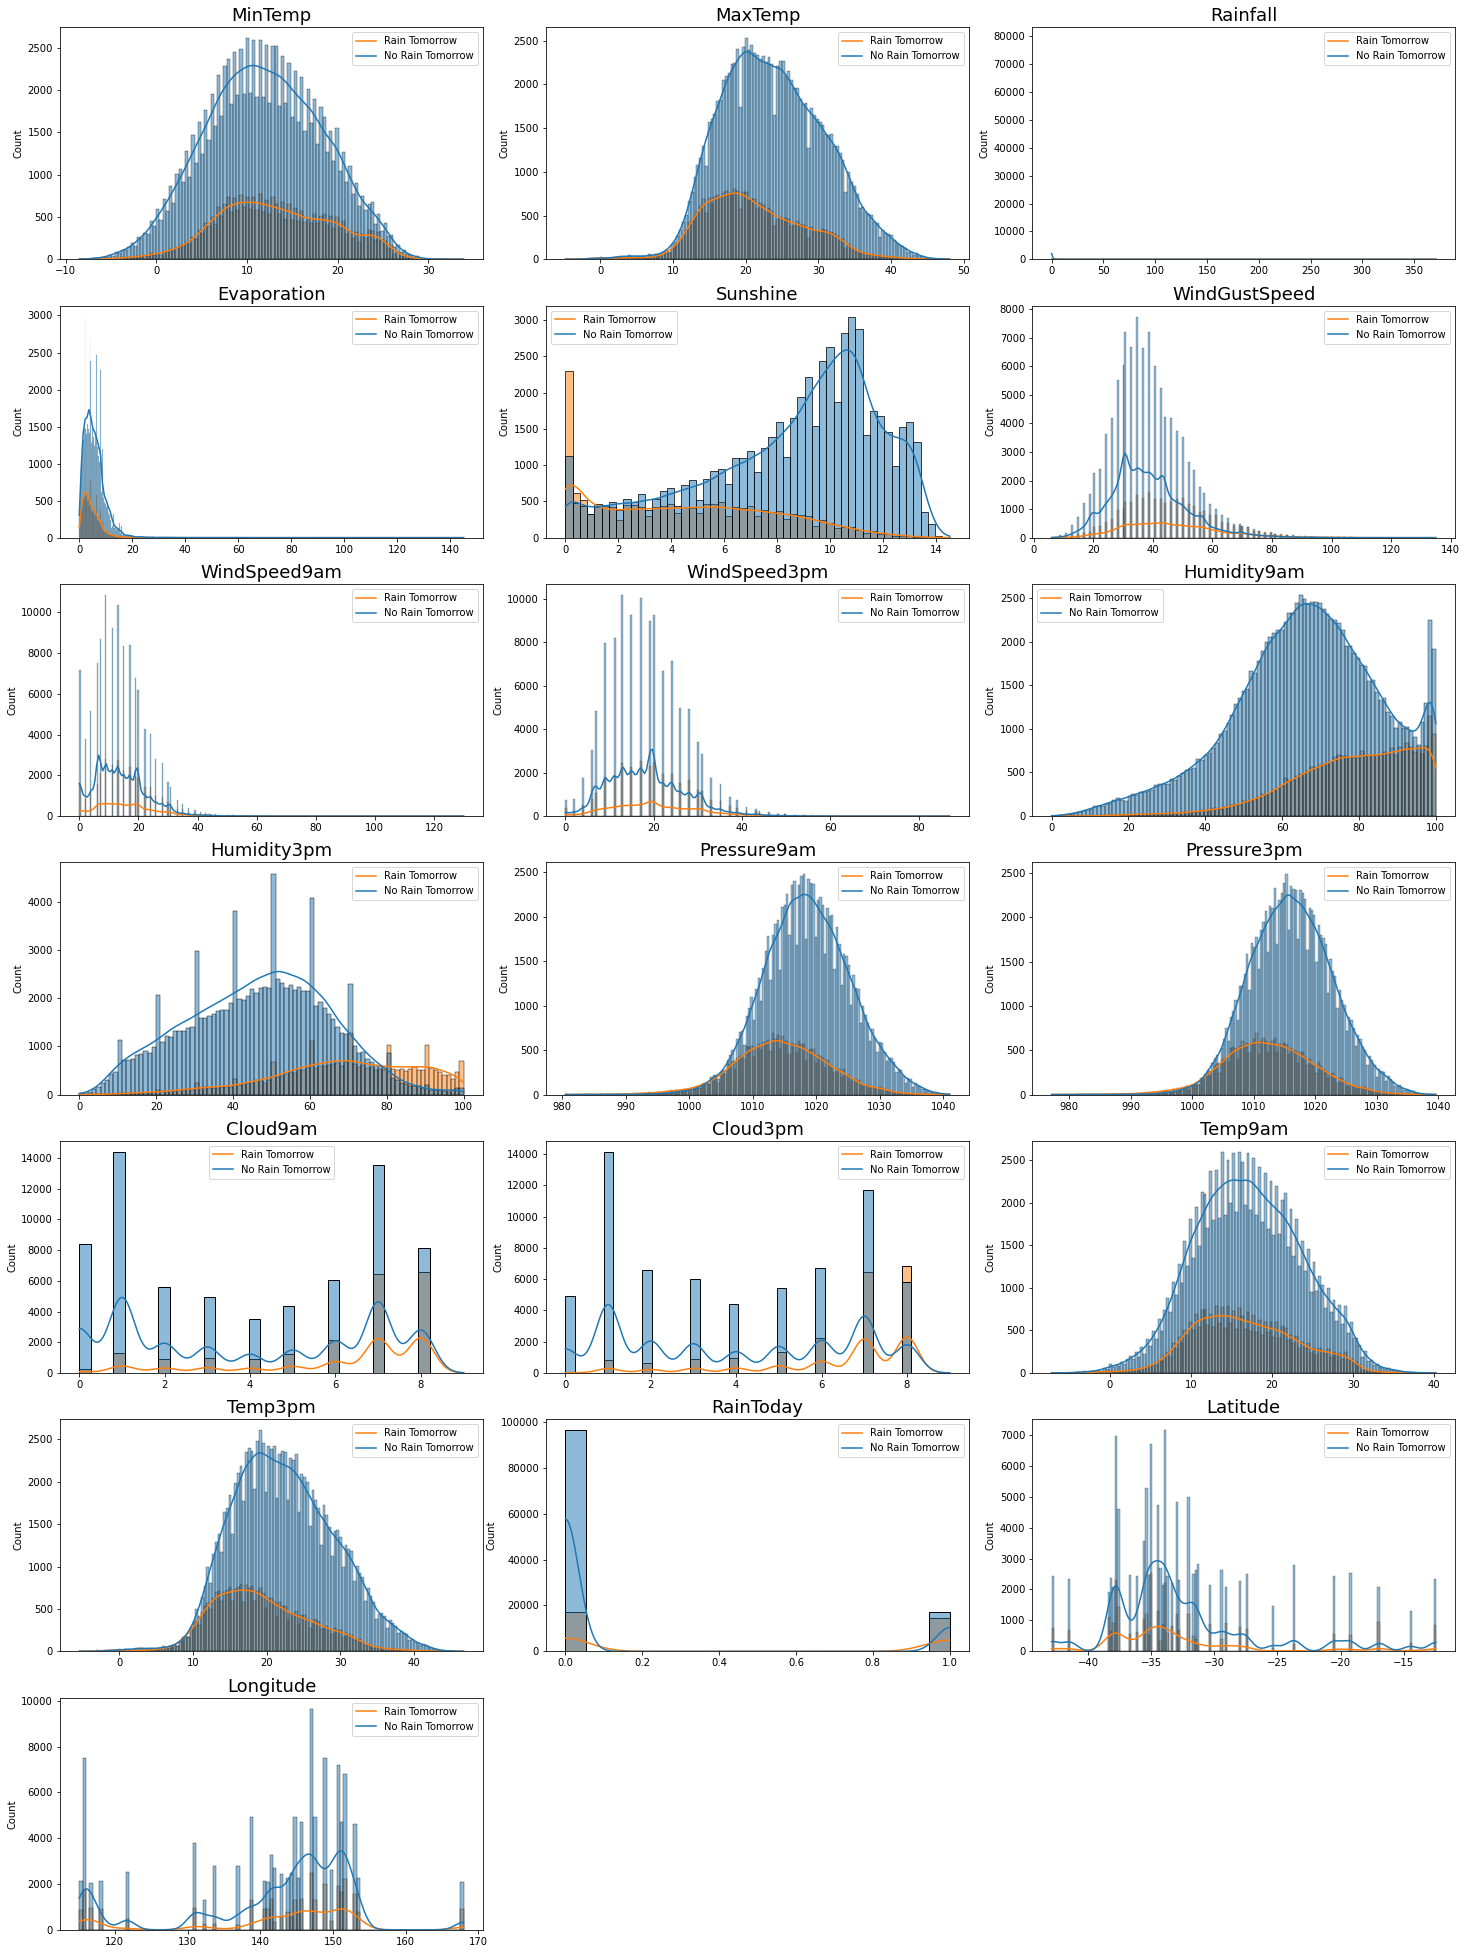

In [24]:
fig = plt.figure(figsize = (25,35))
fig.subplots_adjust(hspace=0.2, wspace=0.15)
i = 1
for col in df_num_plots.columns:
    if col != 'RainTomorrow':
        ax = fig.add_subplot(7, 3, i)
        ax.set_title(col, fontsize = 18)
        hist = sns.histplot(data = df_num_plots,x = col,ax=ax,kde=True, hue ='RainTomorrow')
        hist.set(xlabel = None)
        hist.legend(labels =['Rain Tomorrow', 'No Rain Tomorrow'] )
        i+=1
    else:
        pass
plt.show()

### Let us also look at some pair plots for some of the variables that look like they could be good predictors

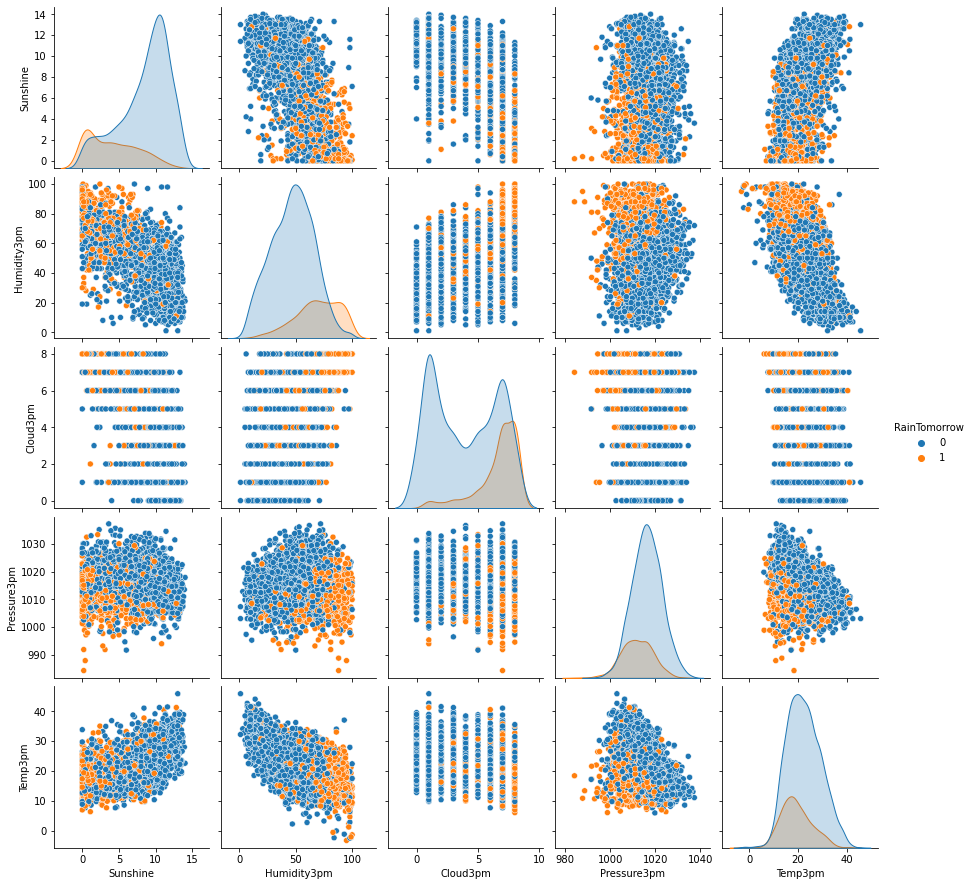

In [28]:
sns.pairplot(df_num_plots[['Sunshine','Humidity3pm','Cloud3pm','Pressure3pm','Temp3pm', 'RainTomorrow']]\
             .sample(frac = 0.03, random_state = 843), hue = 'RainTomorrow')
plt.show()

Next, we look at the values in our non numerical columns

In [14]:
import pyspark.sql.functions as F
df_non_numeric = df.select("Date","WindGustDir","WindDir9am","WindDir3pm")
df_non_numeric.show(4)

+----------+-----------+----------+----------+
|      Date|WindGustDir|WindDir9am|WindDir3pm|
+----------+-----------+----------+----------+
|2007-11-01|         NW|        SW|        NW|
|2007-11-02|        ENE|         E|         W|
|2007-11-03|         NW|         N|       NNE|
|2007-11-04|         NW|       WNW|         W|
+----------+-----------+----------+----------+
only showing top 4 rows



We look at the first and last day in our dataset

In [15]:
min_max_date = df_non_numeric.select(F.min('Date'), F.max('Date')).show()

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2007-11-01|2017-06-25|
+----------+----------+



We look at the distinct values for the rest of the 3 columns

In [16]:
df_non_numeric.groupBy(F.col('WindGustDir')).count().orderBy(F.desc('count')).show()

+-----------+-----+
|WindGustDir|count|
+-----------+-----+
|       null|10326|
|          W| 9915|
|         SE| 9418|
|          N| 9313|
|        SSE| 9216|
|          E| 9181|
|          S| 9168|
|        WSW| 9069|
|         SW| 8967|
|        SSW| 8736|
|        WNW| 8252|
|         NW| 8122|
|        ENE| 8104|
|        ESE| 7372|
|         NE| 7133|
|        NNW| 6620|
|        NNE| 6548|
+-----------+-----+



In [17]:
df_non_numeric.groupBy(F.col('WindDir9am')).count().orderBy(F.desc('count')).show()

+----------+-----+
|WindDir9am|count|
+----------+-----+
|         N|11758|
|      null|10566|
|        SE| 9287|
|         E| 9176|
|       SSE| 9112|
|        NW| 8749|
|         S| 8659|
|         W| 8459|
|        SW| 8423|
|       NNE| 8129|
|       NNW| 7980|
|       ENE| 7836|
|        NE| 7671|
|       ESE| 7630|
|       SSW| 7587|
|       WNW| 7414|
|       WSW| 7024|
+----------+-----+



In [18]:
df_non_numeric.groupBy(F.col('WindDir3pm')).count().orderBy(F.desc('count')).show()

+----------+-----+
|WindDir3pm|count|
+----------+-----+
|        SE|10838|
|         W|10110|
|         S| 9926|
|       WSW| 9518|
|       SSE| 9399|
|        SW| 9354|
|         N| 8890|
|       WNW| 8874|
|        NW| 8610|
|       ESE| 8505|
|         E| 8472|
|        NE| 8263|
|       SSW| 8156|
|       NNW| 7870|
|       ENE| 7857|
|       NNE| 6590|
|      null| 4228|
+----------+-----+



We can see that the unique values are the same but the wind directions are different in the morning vs in the afternoon

### Average daily rainfall in each month by location

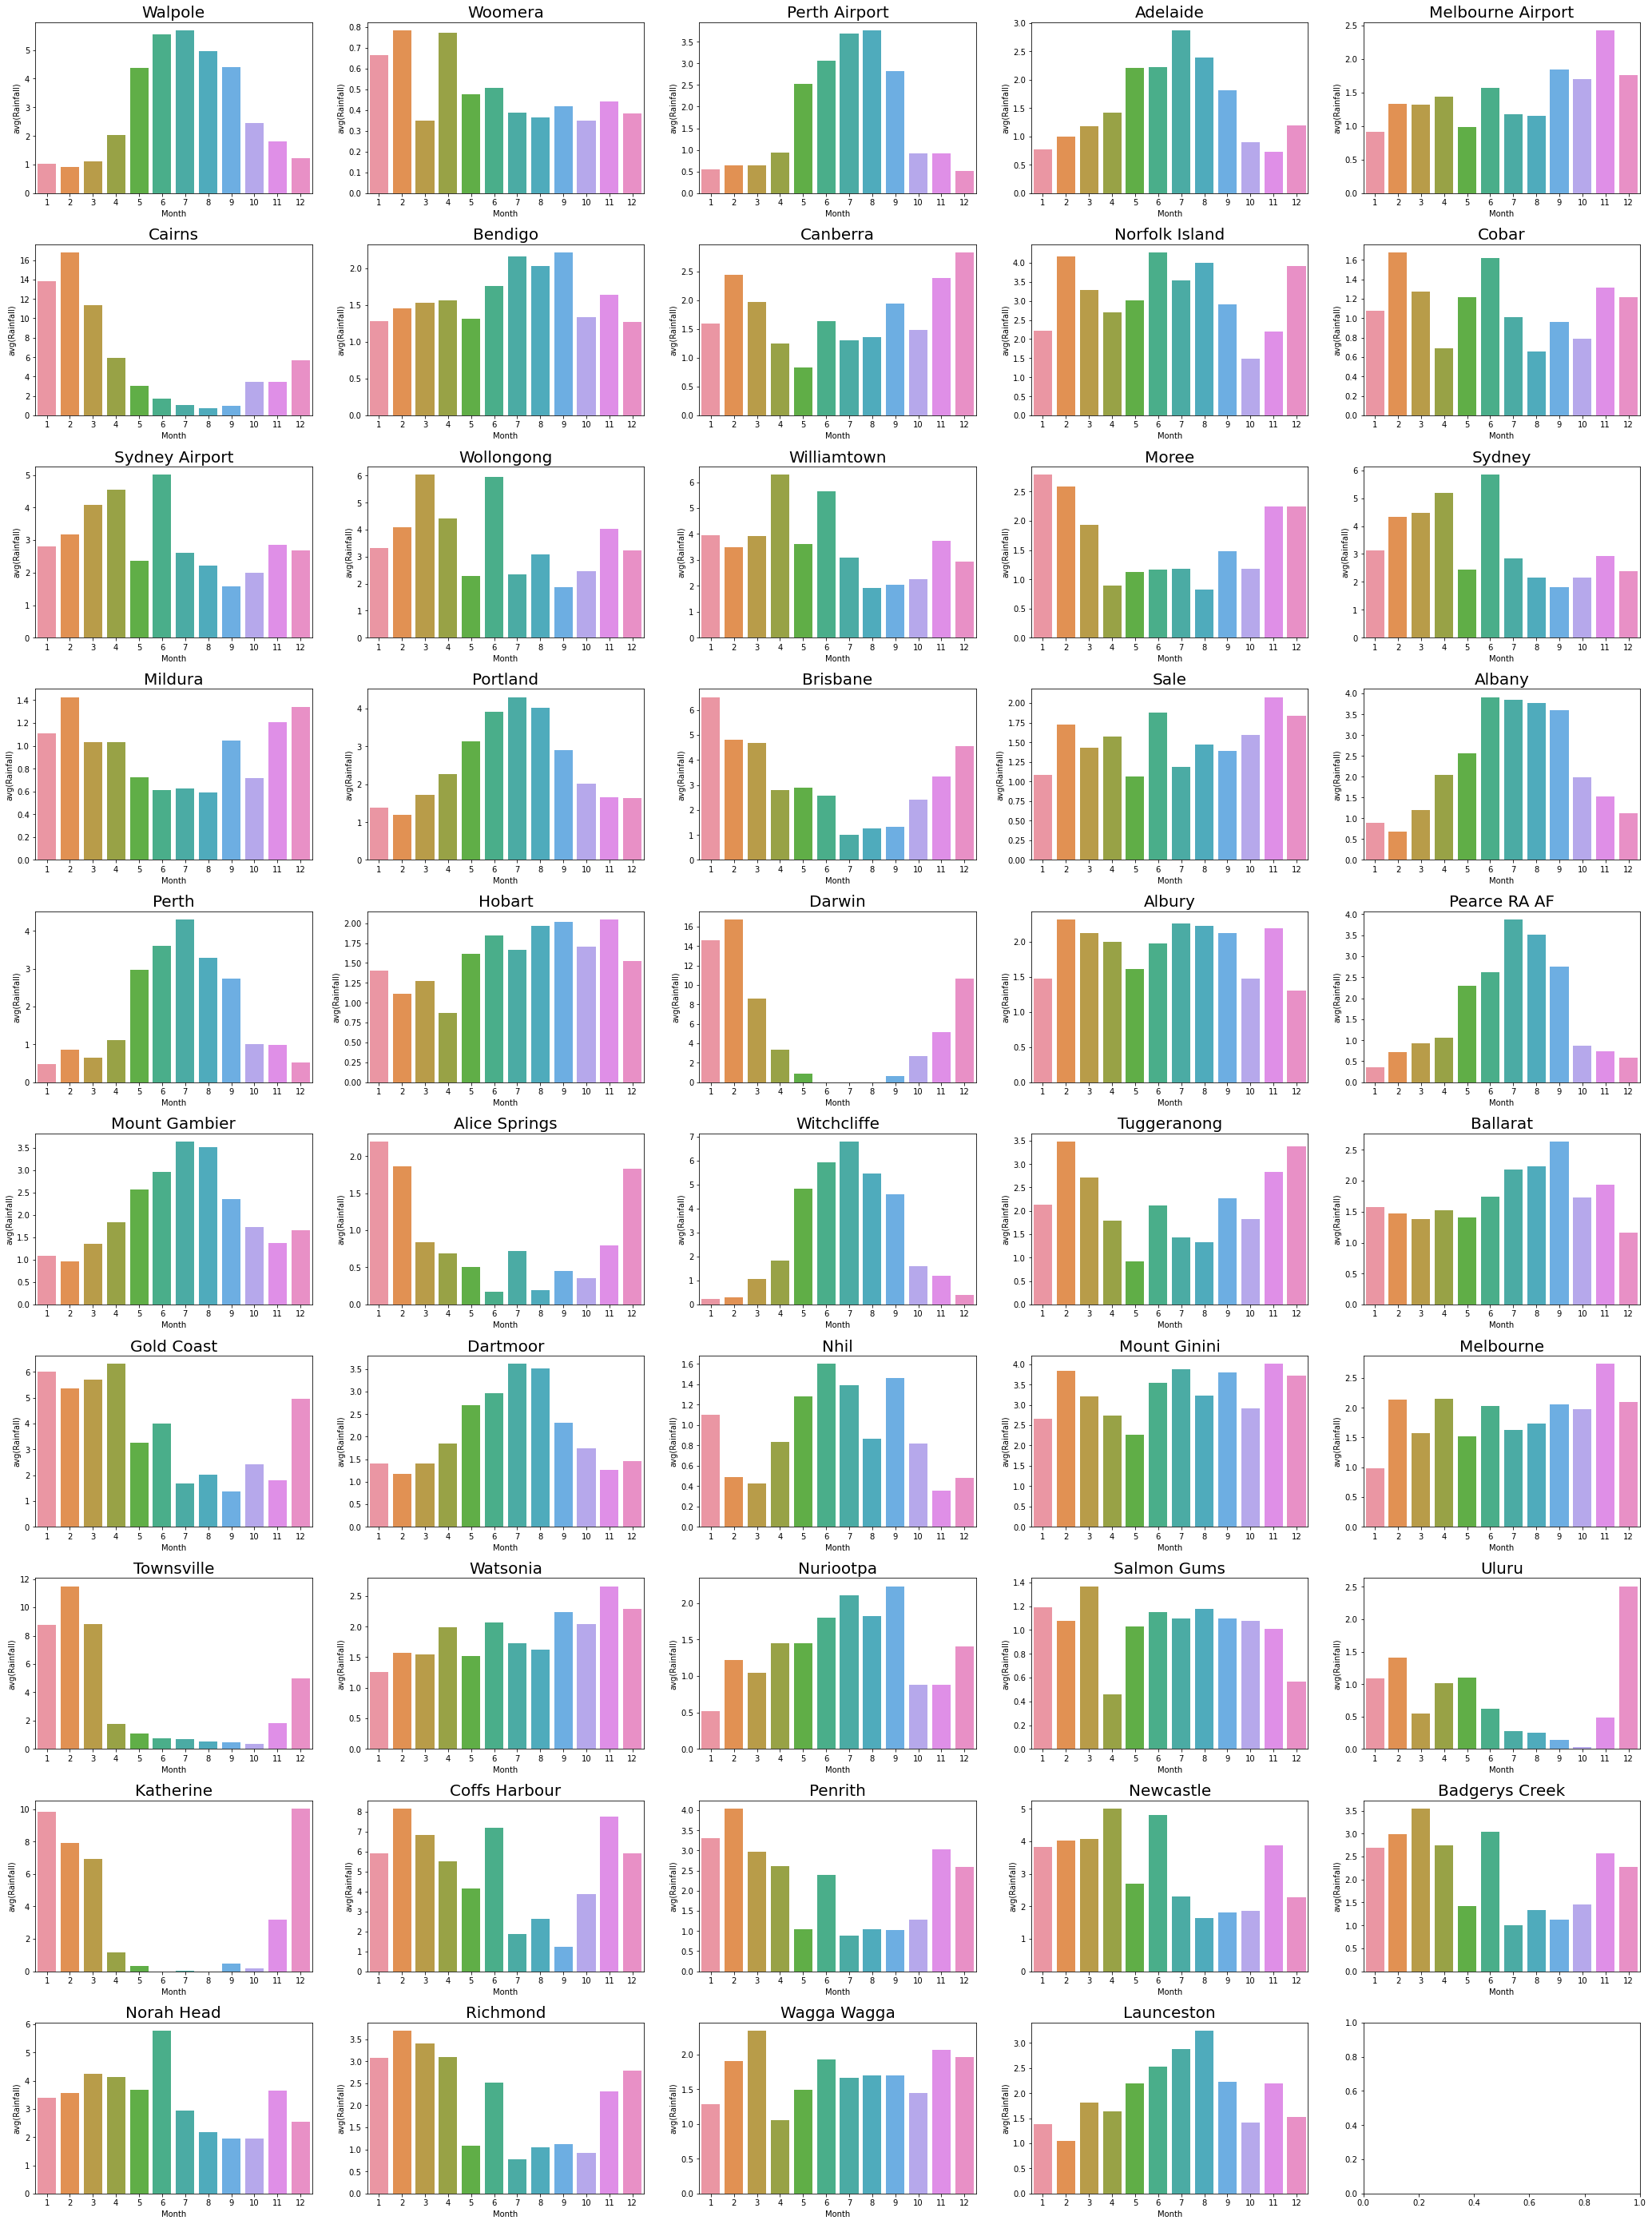

In [19]:
from pyspark.sql.functions import year,month

#extract month from the originial df.
df_withmonth=df.withColumn('Month',month('Date'))

#groupby location and month, agg rainfall
test=df_withmonth.groupBy('Location','Month').avg('Rainfall')

#convert the aggregation to pandas df
df_pandas=test.toPandas()

#get the unique locations
location=df_pandas['Location'].unique()

#plot by location, month, the average monthly rainfall
fig, axes = plt.subplots(10, 5, figsize=(36, 50))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
x=0
y=0
for i in location:
    if y==5:
        y=0
        x+=1
    df_plot=df_pandas[df_pandas['Location']==i]
    sns.barplot(ax=axes[x,y],x='Month',y='avg(Rainfall)',data=df_plot)
    axes[x,y].set_title(i, fontsize = 20)
    y+=1

We can see above that there is a definite seasonality effect in some of the locations. This could be a feature that helps us predict rainfall.

### Average Daily Temperature Difference (Max - Min) by Location
    

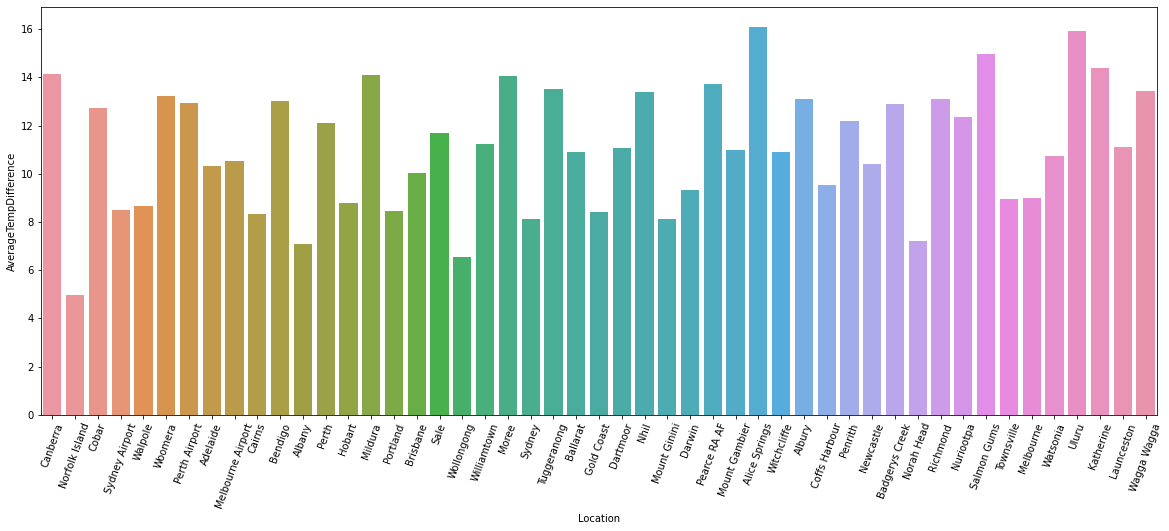

In [20]:
import pyspark.sql.functions as F
df_temp=df.withColumn('tempdif',F.col('MaxTemp')-F.col('MinTemp'))
df_temp_panda=df_temp.groupBy('Location').avg('tempdif').toPandas()
df_temp_panda.columns=['Location','AverageTempDifference']
plt.figure(figsize=(20, 7.5))
plt.xticks(rotation=70)
sns.barplot(x='Location',y='AverageTempDifference',data=df_temp_panda)
plt.show()

We can see that the range of the difference is between approximately 4 and 16 which is a very large range. This could once again be a predictor of rain.

### Average Humidity difference between Afternoon and Morning by Location

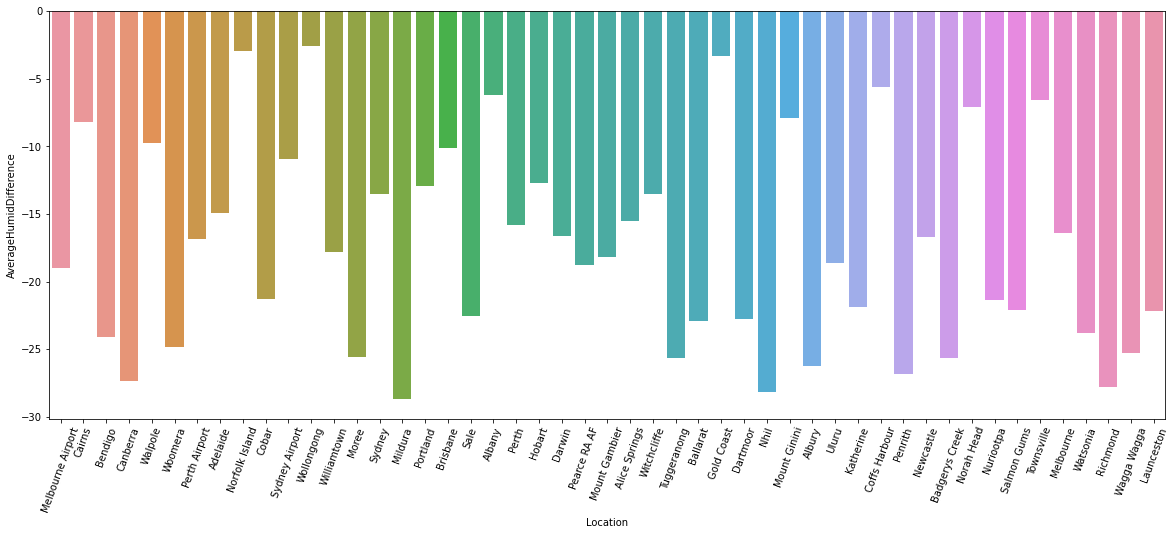

In [21]:
df_temp=df.withColumn('humid_df',F.col('Humidity3pm')-F.col('Humidity9am'))
df_temp_panda=df_temp.groupBy('Location').avg('humid_df').toPandas()
df_temp_panda.columns=['Location','AverageHumidDifference']
plt.figure(figsize=(20, 7.5))
plt.xticks(rotation=70)
sns.barplot(x='Location',y='AverageHumidDifference',data=df_temp_panda)
plt.show()

Just like with temperature, we can see that the range of the difference is very large range. This could once again be a predictor of rain.

### Filling in null values

In [22]:
# This will return a new DF with all the columns + id
df_id = df.withColumn("ID", F.monotonically_increasing_id())

In [23]:
df_num = df_id.drop('Location_idx',"Date","Location","WindGustDir","WindDir9am","WindDir3pm")
df_num.take(2)

[Row(MinTemp=8.0, MaxTemp=24.3, Rainfall=0.0, Evaporation=3.4, Sunshine=6.3, WindGustSpeed=30.0, WindSpeed9am=6.0, WindSpeed3pm=20.0, Humidity9am=68.0, Humidity3pm=29.0, Pressure9am=1019.7, Pressure3pm=1015.0, Cloud9am=7, Cloud3pm=7, Temp9am=14.4, Temp3pm=23.6, RainToday=0, RainTomorrow=1, Latitude=-35.2975906, Longitude=149.1012676, ID=0),
 Row(MinTemp=14.0, MaxTemp=26.9, Rainfall=3.6, Evaporation=4.4, Sunshine=9.7, WindGustSpeed=39.0, WindSpeed9am=4.0, WindSpeed3pm=17.0, Humidity9am=80.0, Humidity3pm=36.0, Pressure9am=1012.4, Pressure3pm=1008.4, Cloud9am=5, Cloud3pm=3, Temp9am=17.5, Temp3pm=25.7, RainToday=1, RainTomorrow=1, Latitude=-35.2975906, Longitude=149.1012676, ID=1)]

In [24]:
df_cat = df_id.select("ID","Date","Location","WindGustDir","WindDir9am","WindDir3pm")
df_cat.take(2)

[Row(ID=0, Date=datetime.date(2007, 11, 1), Location='Canberra', WindGustDir='NW', WindDir9am='SW', WindDir3pm='NW'),
 Row(ID=1, Date=datetime.date(2007, 11, 2), Location='Canberra', WindGustDir='ENE', WindDir9am='E', WindDir3pm='W')]

In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=df_num.columns, 
    outputCols=[c for c in df_num.columns]#outputCols=["{}_imputed".format(c) for c in df_num.columns]
    ).setStrategy("median")

# Add imputation cols to df
df_median= imputer.fit(df_num).transform(df_num)
df_median.take(2)

[Row(MinTemp=8.0, MaxTemp=24.3, Rainfall=0.0, Evaporation=3.4, Sunshine=6.3, WindGustSpeed=30.0, WindSpeed9am=6.0, WindSpeed3pm=20.0, Humidity9am=68.0, Humidity3pm=29.0, Pressure9am=1019.7, Pressure3pm=1015.0, Cloud9am=7, Cloud3pm=7, Temp9am=14.4, Temp3pm=23.6, RainToday=0, RainTomorrow=1, Latitude=-35.2975906, Longitude=149.1012676, ID=0),
 Row(MinTemp=14.0, MaxTemp=26.9, Rainfall=3.6, Evaporation=4.4, Sunshine=9.7, WindGustSpeed=39.0, WindSpeed9am=4.0, WindSpeed3pm=17.0, Humidity9am=80.0, Humidity3pm=36.0, Pressure9am=1012.4, Pressure3pm=1008.4, Cloud9am=5, Cloud3pm=3, Temp9am=17.5, Temp3pm=25.7, RainToday=1, RainTomorrow=1, Latitude=-35.2975906, Longitude=149.1012676, ID=1)]

In [26]:
df_median.select([count(when(isnull(column), column)).alias("Null values in "+ column) for column in df_median.columns]).show()

+----------------------+----------------------+-----------------------+--------------------------+-----------------------+----------------------------+---------------------------+---------------------------+--------------------------+--------------------------+--------------------------+--------------------------+-----------------------+-----------------------+----------------------+----------------------+------------------------+---------------------------+-----------------------+------------------------+-----------------+
|Null values in MinTemp|Null values in MaxTemp|Null values in Rainfall|Null values in Evaporation|Null values in Sunshine|Null values in WindGustSpeed|Null values in WindSpeed9am|Null values in WindSpeed3pm|Null values in Humidity9am|Null values in Humidity3pm|Null values in Pressure9am|Null values in Pressure3pm|Null values in Cloud9am|Null values in Cloud3pm|Null values in Temp9am|Null values in Temp3pm|Null values in RainToday|Null values in RainTomorrow|Null val

In [27]:
from pyspark.sql.functions import month
df_cat= df_cat.withColumn('Month',F.month('Date'))
df_cat.show(5)

+---+----------+--------+-----------+----------+----------+-----+
| ID|      Date|Location|WindGustDir|WindDir9am|WindDir3pm|Month|
+---+----------+--------+-----------+----------+----------+-----+
|  0|2007-11-01|Canberra|         NW|        SW|        NW|   11|
|  1|2007-11-02|Canberra|        ENE|         E|         W|   11|
|  2|2007-11-03|Canberra|         NW|         N|       NNE|   11|
|  3|2007-11-04|Canberra|         NW|       WNW|         W|   11|
|  4|2007-11-05|Canberra|        SSE|       SSE|       ESE|   11|
+---+----------+--------+-----------+----------+----------+-----+
only showing top 5 rows



In [28]:
df_cat = df_cat.drop('Date')
df_cat.show(5)

+---+--------+-----------+----------+----------+-----+
| ID|Location|WindGustDir|WindDir9am|WindDir3pm|Month|
+---+--------+-----------+----------+----------+-----+
|  0|Canberra|         NW|        SW|        NW|   11|
|  1|Canberra|        ENE|         E|         W|   11|
|  2|Canberra|         NW|         N|       NNE|   11|
|  3|Canberra|         NW|       WNW|         W|   11|
|  4|Canberra|        SSE|       SSE|       ESE|   11|
+---+--------+-----------+----------+----------+-----+
only showing top 5 rows



In [29]:
df_cat.select([count(when(isnull(column), column)).alias("Null values in "+ column) for column in df_cat.columns]).show()

+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+
|Null values in ID|Null values in Location|Null values in WindGustDir|Null values in WindDir9am|Null values in WindDir3pm|Null values in Month|
+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+
|                0|                      0|                     10326|                    10566|                     4228|                   0|
+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+



Below we find the most common values by location for the columns with null values from above

In [30]:
# df_cat.createOrReplaceTempView('df_cat')

# wind_gust_directions = spark.sql("""
# SELECT  Location, WindGustDir, COUNT(WindGustDir) AS counts
# FROM df_cat
# GROUP BY Location, WindGustDir
# ORDER BY counts DESC
# """)

# wind_gust_directions.createOrReplaceTempView('wind_gust_directions')

# most_common_windgustdir_by_location = spark.sql("""
# SELECT t1.Location, t2.WindGustDir AS MostCommonWindGustDir
# FROM (SELECT Location, MAX(counts) as max_count
#       FROM wind_gust_directions
#       GROUP BY Location) t1
# LEFT JOIN wind_gust_directions t2
# ON (t1.Location = t2.Location AND t1.max_count = t2.counts)
# ORDER BY Location
# """)
# most_common_windgustdir_by_location.show(10)


# def fillWindGust(WindGustDir, Location):
#     fill_vals = most_common_windgustdir_by_location.toPandas().set_index('Location').to_dict()
#     if not WindGustDir:
#         return fill_vals['MostCommonWindGustDir'][Location]
#     return WindGustDir

# fillWindGustUDF = F.udf(lambda x,y:fillWindGust(x,y), StringType())
# spark.udf.register("fillWindGustUDF", fillWindGustUDF)

# df_cat.withColumn('TestingFill',fillWindGustUDF('WindGustDir','Location')).show(10)

In [31]:
# wind_9am_directions = spark.sql("""
# SELECT  Location, WindDir9am, COUNT(WindDir9am) AS counts
# FROM df_cat
# GROUP BY Location, WindDir9am
# ORDER BY counts DESC
# """)

# wind_9am_directions.createOrReplaceTempView('wind_9am_directions')

# most_common_wind_9am_directions_by_location = spark.sql("""
# SELECT t1.Location, t2.WindDir9am AS MostCommonWindDir9am
# FROM (SELECT Location, MAX(counts) as max_count
#       FROM wind_9am_directions
#       GROUP BY Location) t1
# LEFT JOIN wind_9am_directions t2
# ON (t1.Location = t2.Location AND t1.max_count = t2.counts)
# ORDER BY Location
# """)
# most_common_wind_9am_directions_by_location.show(10)

In [32]:
# wind_3pm_directions = spark.sql("""
# SELECT  Location, WindDir3pm, COUNT(WindDir3pm) AS counts
# FROM df_cat
# GROUP BY Location, WindDir3pm
# ORDER BY counts DESC
# """)

# wind_3pm_directions.createOrReplaceTempView('wind_3pm_directions')

# most_common_wind_3pm_directions_by_location = spark.sql("""
# SELECT t1.Location, t2.WindDir3pm AS MostCommonWindDir3pm
# FROM (SELECT Location, MAX(counts) as max_count
#       FROM wind_3pm_directions
#       GROUP BY Location) t1
# LEFT JOIN wind_3pm_directions t2
# ON (t1.Location = t2.Location AND t1.max_count = t2.counts)
# ORDER BY Location
# """)
# most_common_wind_3pm_directions_by_location.show(10)

### It seems we are unable to fill by specific location, so we just fill by the most common value of the column overall

In [33]:
df_cat.createOrReplaceTempView('df_cat')

#WindGustDir most common value
mostCommonWindGustDir = spark.sql("""
SELECT WindGustDir, COUNT(WindGustDir) as n_occurences
FROM df_cat
GROUP BY WindGustDir
ORDER BY n_occurences DESC
LIMIT 1
""").collect()[0][0]

#WinDir9am most common value
mostCommonWindDir9am = spark.sql("""
SELECT WindDir9am, COUNT(WindDir9am) as n_occurences
FROM df_cat
GROUP BY WindDir9am
ORDER BY n_occurences DESC
LIMIT 1
""").collect()[0][0]

#WindDir3pm most common value
mostCommonWindDir3pm = spark.sql("""
SELECT WindDir3pm, COUNT(WindDir3pm) as n_occurences
FROM df_cat
GROUP BY WindDir3pm
ORDER BY n_occurences DESC
LIMIT 1
""").collect()[0][0]

In [34]:
print('mostCommonWindGustDir:',mostCommonWindGustDir)
print('mostCommonWindDir9am:' ,mostCommonWindDir9am)
print('mostCommonWindDir3pm:' ,mostCommonWindDir3pm)

mostCommonWindGustDir: W
mostCommonWindDir9am: N
mostCommonWindDir3pm: SE


In [35]:
fill_vals = {'WindGustDir':mostCommonWindGustDir,'WindDir9am': mostCommonWindDir9am, 'WindDir3pm':mostCommonWindDir3pm}
df_cat = df_cat.fillna(fill_vals)
df_cat.select([count(when(isnull(column), column)).alias("Null values in "+ column) for column in df_cat.columns]).show()

+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+
|Null values in ID|Null values in Location|Null values in WindGustDir|Null values in WindDir9am|Null values in WindDir3pm|Null values in Month|
+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+
|                0|                      0|                         0|                        0|                        0|                   0|
+-----------------+-----------------------+--------------------------+-------------------------+-------------------------+--------------------+



In [36]:
df_filled = df_median.join(df_cat, "ID").drop('ID')
df_filled.take(2)

[Row(MinTemp=13.3, MaxTemp=22.2, Rainfall=0.2, Evaporation=6.6, Sunshine=2.3, WindGustSpeed=39.0, WindSpeed9am=20.0, WindSpeed3pm=17.0, Humidity9am=70.0, Humidity3pm=55.0, Pressure9am=1021.0, Pressure3pm=1018.6, Cloud9am=7, Cloud3pm=7, Temp9am=16.5, Temp3pm=21.2, RainToday=0, RainTomorrow=0, Latitude=-35.2975906, Longitude=149.1012676, Location='Canberra', WindGustDir='ENE', WindDir9am='E', WindDir3pm='E', Month=11),
 Row(MinTemp=13.6, MaxTemp=24.1, Rainfall=0.4, Evaporation=2.6, Sunshine=0.5, WindGustSpeed=30.0, WindSpeed9am=6.0, WindSpeed3pm=6.0, Humidity9am=83.0, Humidity3pm=49.0, Pressure9am=1017.2, Pressure3pm=1013.3, Cloud9am=8, Cloud3pm=7, Temp9am=17.3, Temp3pm=23.2, RainToday=0, RainTomorrow=1, Latitude=-35.2975906, Longitude=149.1012676, Location='Canberra', WindGustDir='NNW', WindDir9am='SSW', WindDir3pm='S', Month=11)]

In [37]:
print("Number of rows:",df_filled.count())

Number of rows: 145460


We see above that we have not lost any rows.

Below, we check one more time to see if we have any null values left. We should not see any at this point.

In [38]:
df_filled.select([count(when(isnull(c), c)).alias(c) for c in df_filled.columns]).show()

+-------+-------+--------+-----------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+--------+---------+--------+-----------+----------+----------+-----+
|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|Latitude|Longitude|Location|WindGustDir|WindDir9am|WindDir3pm|Month|
+-------+-------+--------+-----------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+--------+---------+--------+-----------+----------+----------+-----+
|      0|      0|       0|          0|       0|            0|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|        0|           0|       0|        0|      

# Indexing, Encoding and Assembling

In [40]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

#getting rid of location since we now have coordinates
cat_cols = ['WindGustDir','WindDir9am','WindDir3pm','Month']
num_cols = df_num.drop('ID').columns 
cat_cols_out_names = [col_name + 'Indexed' for col_name in cat_cols]
cat_cols_one_hot_names = [col_name + 'OneHot' for col_name in cat_cols_out_names]
feature_cols = cat_cols_one_hot_names + num_cols
target = 'RainTomorrow'
feature_cols.remove(target)

#Indexing the categorical string columns
indexer = StringIndexer(inputCols=cat_cols, outputCols=cat_cols_out_names)
indexed = indexer.fit(df_filled).transform(df_filled).drop(*cat_cols)

#One Hot encoding the categorical columns
encoder = OneHotEncoder(inputCols=cat_cols_out_names,
                        outputCols=cat_cols_one_hot_names)
model = encoder.fit(indexed)
encoded = model.transform(indexed).drop(*cat_cols_out_names)

#Assembling all the features into a vector
#Keeping RainToday for comparing to a baseline model later
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features")
vectored_data = assembler.transform(encoded).select('RainTomorrow','features', 'RainToday')
vectored_data = vectored_data.withColumnRenamed('RainTomorrow','label')
vectored_data.show(2, False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|label|features                                                                                                                                                                                         |RainToday|
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|0    |(75,[11,17,40,52,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74],[1.0,1.0,1.0,1.0,13.3,22.2,0.2,6.6,2.3,39.0,20.0,17.0,70.0,55.0,1021.0,1018.6,7.0,7.0,16.5,21.2,-35.2975906,149.1012676])|0        |
|1    |(75,[14,28,32,52,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74],[1.0,1.0,1.0,1.0,13.6,24.1,0.4,2.6,0.5,30.0,6.0,6.0,83.0,49.0,1017.2,1013

# Testing out models

In [61]:
(training_data, test_data) = vectored_data.randomSplit([0.800,0.200], seed = 843)

In [42]:
#looking at the distribution of labels in the test set
val_counts = test_data.groupBy('label').count()
tot_count = test_data.count()
val_counts.withColumn('Percentage_count',F.col('count')/tot_count).show()

+-----+-----+------------------+
|label|count|  Percentage_count|
+-----+-----+------------------+
|    0|22877|0.7798534174194648|
|    1| 6384|0.2176239986364411|
+-----+-----+------------------+



In [43]:
#defining the evaluation metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol='label', 
    predictionCol='prediction', 
    metricName='accuracy')

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='label', 
    predictionCol='prediction', 
    metricName='f1')

evaluator_auc = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#Getting the true values of the label to use with some sklearn classification reports
y_true = test_data.select('label').rdd.map(lambda r : r[0]).collect()

## Baseline Model

We start by considering a rule where we just predict that it will rain tomorrow if it rained today and no rain tomorrow if it did not rain today.

Test Accuracy =  0.7619356823075083
Test F1 score =  0.7622431941827936


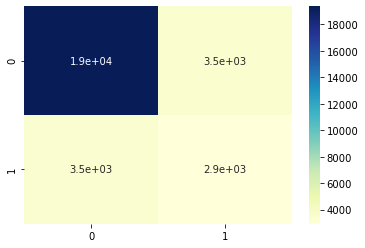

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     22877
           1       0.45      0.46      0.46      6384

    accuracy                           0.76     29261
   macro avg       0.65      0.65      0.65     29261
weighted avg       0.76      0.76      0.76     29261



In [45]:
#always predicting yesterday's label 
df_baseline_model = test_data.withColumn('prediction',F.col('RainToday').cast(DoubleType()))\
                             .withColumnRenamed('RainTomorrow','label')\
                             .select('label','prediction')

accuracy = evaluator_acc.evaluate(df_baseline_model)
print('Test Accuracy = ', accuracy) 

f1 = evaluator_f1.evaluate(df_baseline_model)
print('Test F1 score = ', f1) 

y_pred = df_baseline_model.select('prediction').rdd.map(lambda x: x[0]).collect()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap = "YlGnBu")
plt.show()
print(classification_report(y_true, y_pred))

As we can see, the accuracy is 76% and the F-1 score on label 1 is only 46%

In [50]:
#Dropping RainToday since we are no longer using it
training_data = training_data.drop('RainToday')
test_data = test_data.drop('RainToday')

## Tuning other models
We will use F-1 score to tune our models since we want to make sure we predict the positive labels correctly as much as possible

In [55]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

### Logistic Regression
We consider a logistic regression and we run a grid search to find the best model

Logistic Regression Best Model:
Elastic Net Param: 0.0
Reg Param: 0.1
Fit Intercept: False
Test Accuracy =  0.8165106266657555
Test F1 score =  0.7849034490090356
Test AUC score =  0.8194595367919671


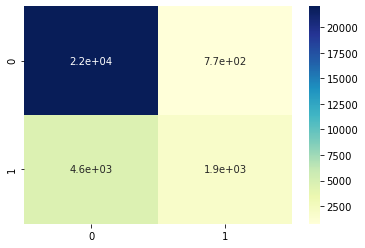

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     22804
           1       0.71      0.29      0.41      6462

    accuracy                           0.82     29266
   macro avg       0.77      0.63      0.65     29266
weighted avg       0.80      0.82      0.78     29266



In [ ]:
"""
DO NOT RUN AGAIN!!!
"""
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='label', featuresCol='features', maxIter=15)  # defining stage 2 by instantiating an instance of LogisticRegression

# building the hyperparameter grid
params = ParamGridBuilder()\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.fitIntercept, [False, True])\
  .addGrid(lr.regParam, [0.1, 1, 2.0])\
  .build()

# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params)\
  .setEstimator(lr)\
  .setEvaluator(evaluator_f1)

tvsFitted = tvs.fit(training_data)  # fit the estimator

predictions = tvsFitted.transform(test_data)

print('Logistic Regression Best Model:')
print('Elastic Net Param:', tvsFitted.bestModel.getElasticNetParam())
print('Reg Param:', tvsFitted.bestModel.getRegParam())
print('Fit Intercept:', tvsFitted.bestModel.getFitIntercept())

accuracy = evaluator_acc.evaluate(predictions)
print('Test Accuracy = ', accuracy) 

f1 = evaluator_f1.evaluate(predictions)
print('Test F1 score = ', f1) 

auc = evaluator_auc.evaluate(predictions)
print('Test AUC score = ', auc) 

y_pred = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap = "YlGnBu")
plt.show()
print(classification_report(y_true, y_pred))

We can see a slight improvement in terms of accuracy over the baseline model, however the f1 score is actually lower

### Random Forest

Then we run a grid search on a Random Forest Classifier

Random Forest Classifier Best Model
Max Depth: 15
Number of Trees: 30
Min Instances per Node: 1
Test Accuracy =  0.8521492516913824
Test F1 score =  0.8383857377294721
Test AUC score =  0.8740688347312485


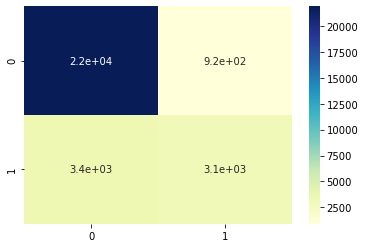

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     22804
           1       0.77      0.47      0.59      6462

    accuracy                           0.85     29266
   macro avg       0.82      0.72      0.75     29266
weighted avg       0.84      0.85      0.84     29266



In [64]:
"""
DO NOT RUN AGAIN!!!
"""
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features')  

params = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [5,10,15])\
  .addGrid(rf.numTrees, [5,15,30])\
  .addGrid(rf.minInstancesPerNode,[1,2])\
  .build()

tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params)\
  .setEstimator(rf)\
  .setEvaluator(evaluator_f1)

tvsFitted = tvs.fit(training_data)  

predictions = tvsFitted.transform(test_data)

print('Random Forest Classifier Best Model')
print('Max Depth:', tvsFitted.bestModel.getMaxDepth())
print('Number of Trees:', tvsFitted.bestModel.getNumTrees)
print('Min Instances per Node:', tvsFitted.bestModel.getMinInstancesPerNode())

accuracy = evaluator_acc.evaluate(predictions)
print('Test Accuracy = ', accuracy) 

f1 = evaluator_f1.evaluate(predictions)
print('Test F1 score = ', f1) 

auc = evaluator_auc.evaluate(predictions)
print('Test AUC score = ', auc) 

y_pred = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap = "YlGnBu")
plt.show()
print(classification_report(y_true, y_pred))

The Random Forest Classifier is a significant improvement over both our baseline model and the logistic regression in terms of both accuracy and f1 score

### Linear Support Vector Classifier

Then we run a grid search on a Support Vector Classifier

Linear Support Vector Classifier Best Model
Regularization Param: 0.0
Fit Intercept: True
Test Accuracy =  0.7863390965625641
Test F1 score =  0.711694581594432
Test AUC score =  0.8071542586125864


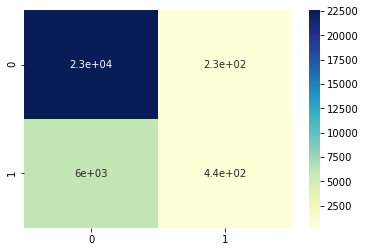

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     22804
           1       0.66      0.07      0.12      6462

    accuracy                           0.79     29266
   macro avg       0.72      0.53      0.50     29266
weighted avg       0.76      0.79      0.71     29266



In [ ]:
"""
DO NOT RUN AGAIN!!!
"""
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(labelCol='label', featuresCol='features', maxIter = 50)

params = ParamGridBuilder()\
  .addGrid(svc.regParam, [0,0.1,0.5,1])\
  .build()

tvs = TrainValidationSplit()\
  .setTrainRatio(0.7)\
  .setEstimatorParamMaps(params)\
  .setEstimator(svc)\
  .setEvaluator(evaluator_f1)

tvsFitted = tvs.fit(training_data)  # fit the estimator

predictions = tvsFitted.transform(test_data)

print('Linear Support Vector Classifier Best Model')
print('Regularization Param:', tvsFitted.bestModel.getRegParam())

accuracy = evaluator_acc.evaluate(predictions)
print('Test Accuracy = ', accuracy) 

f1 = evaluator_f1.evaluate(predictions)
print('Test F1 score = ', f1) 

auc = evaluator_auc.evaluate(predictions)
print('Test AUC score = ', auc) 

y_pred = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap = "YlGnBu")
plt.show()
print(classification_report(y_true, y_pred))

Unfortunately, the SVC performs very poorly on the positive label

### Gradient Booster Tree Classifier
Finally, we look at a Gradient Boosted Tree Classifier. Here we do not run a grid search due to the fact that it takes very long to run. An attempt to run a grid search with 12 models did not finish running in over 7 hours on a cluster with 4 worker nodes.

Gradient Boosted Tree Classifier Model
Test Accuracy =  0.8259755347502221
Test F1 score =  0.8194716305706484
Test AUC score =  0.8455901721347381


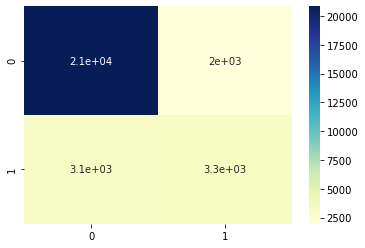

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     22804
           1       0.63      0.52      0.57      6462

    accuracy                           0.83     29266
   macro avg       0.75      0.71      0.73     29266
weighted avg       0.82      0.83      0.82     29266



In [ ]:
"""
DO NOT RUN AGAIN!!!
"""
from pyspark.ml.classification import GBTClassifier

"""
The below code was taking over 7hrs to run
We decided to go with a specific model rather than run a grid search
"""
# gbt = GBTClassifier(labelCol='label', featuresCol='features') 

# params = ParamGridBuilder()\
#   .addGrid(gbt.maxDepth, [5,10,15])\
#   .addGrid(gbt.maxBins, [16,32])\
#   .addGrid(gbt.minInstancesPerNode,[1,2])\
#   .build()

# tvs = TrainValidationSplit()\
#   .setTrainRatio(0.7)\
#   .setEstimatorParamMaps(params)\
#   .setEstimator(gbt)\
#   .setEvaluator(evaluator_f1)

# tvsFitted = tvs.fit(training_data)  

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxDepth = 15, minInstancesPerNode = 1, seed = 843) 

tvsFitted = gbt.fit(training_data)

predictions = tvsFitted.transform(test_data)

print('Gradient Boosted Tree Classifier Model')

accuracy = evaluator_acc.evaluate(predictions)
print('Test Accuracy = ', accuracy) 

f1 = evaluator_f1.evaluate(predictions)
print('Test F1 score = ', f1) 

auc = evaluator_auc.evaluate(predictions)
print('Test AUC score = ', auc) 

y_pred = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap = "YlGnBu")
plt.show()
print(classification_report(y_true, y_pred))

Here we see that the GBT Classifier performs much better than the baseline model, however it does not outperform the Random Forest. This is likely due to the fact that this model has randomly picked hyperparameters. If we were able to run the grid search with a lot of hypermparameters it is highly likely that a GBT Classifier would outperform the Random Forest model. 

## Results Summary


| Model      | F1 score (overall) | F1 score (positive label) | Accuracy     | AUC score |
| :------        |    :----:   |         :---: |:---: |---: |
| Baseline    | 0.76       | 0.46   | 0.76 | N/A|
| Logistic Regression  | 0.78 | 0.41 |0.82 | 0.82 |
| Random Forest   | 0.84 | 0.59|0.85 | 0.87 |
| Linear SVC   |0.71 | 0.12|0.79 |0.81 |
| Gradient Boosted Tree|0.82 | 0.57 |0.83 |0.85 |

From the table above, we see that the Random Forest outperforms every other model in all metrics. 

However, we are sure that there exist models that can further improve on all of the metrics above. Unfortunately, due to limited budget we were unable to run more extensive grid searches to tune hyperparameters that would enable us to find those models.